In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.cluster
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from sklearn.metrics import rand_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from vqvae.foster import VectorQuantizedVariationalAutoencoder
from utils import create_dataframe_for_embeddings, create_dataframe_for_latent_projections
%matplotlib inline

In [5]:
checkpoint_path = "checkpoints/vqvae-mnist/3egcex62/checkpoints/epoch=82-step=4814.ckpt"

In [6]:
model = VectorQuantizedVariationalAutoencoder.load_from_checkpoint(checkpoint_path)
model.eval()
cfg = model.hparams.cfg

In [7]:
train_dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
val_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, drop_last=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False, drop_last=True, num_workers=4)

In [8]:
df_embeddings = create_dataframe_for_embeddings(model, cfg)

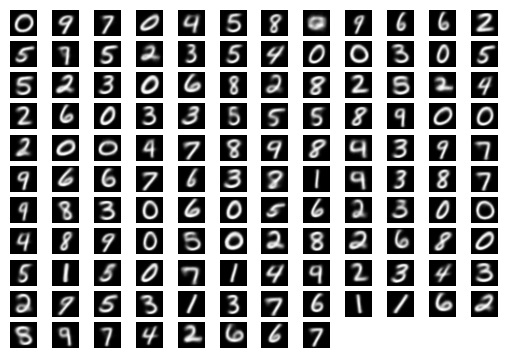

In [9]:
N = int(np.ceil(np.sqrt(cfg.vq.num_embeddings)))

for i in range(cfg.vq.num_embeddings):
    plt.subplot(N, N, i + 1)
    plt.imshow(df_embeddings.loc[i, 'Image'], cmap="gray")
    plt.axis('off')

In [10]:
df_latent_projection = create_dataframe_for_latent_projections(model, val_dataloader, cfg)

100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


In [13]:
import umap

reducer = umap.UMAP(n_neighbors=50)
z_data = df_latent_projection.drop(['Label', 'Embedding Index'], axis=1).values
scaled_z_data = StandardScaler().fit_transform(z_data)
embedding = reducer.fit_transform(scaled_z_data)

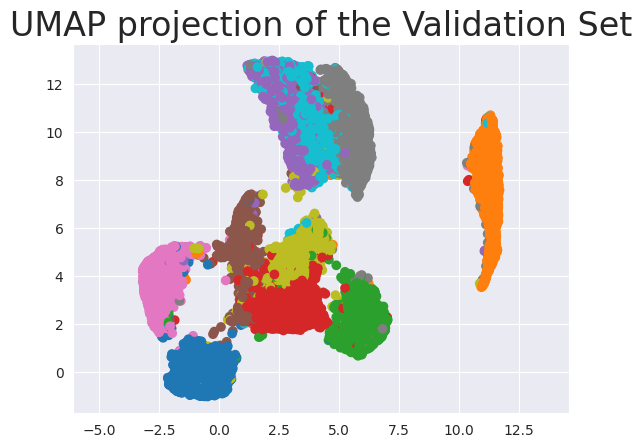

In [30]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in df_latent_projection.Label.astype(int)])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Validation Set', fontsize=24);

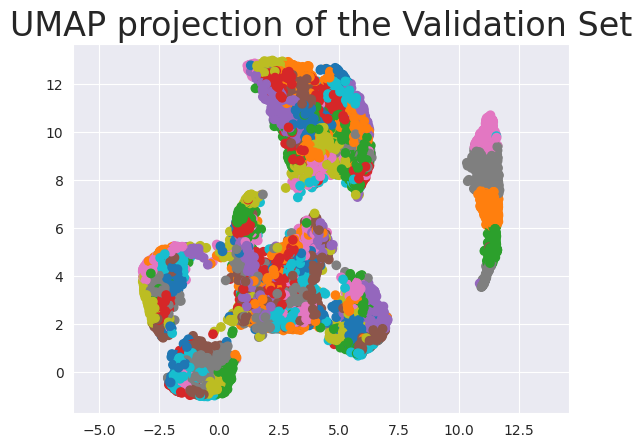

In [31]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette(n_colors=128)[x] for x in df_latent_projection['Embedding Index'].astype(int)])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Validation Set', fontsize=24);

In [32]:
clf = sklearn.cluster.KMeans(n_clusters=10, n_init='auto')
clf.fit(df_embeddings.drop("Image", axis=1))
embeddings_to_cluster_map = clf.predict(df_embeddings.drop("Image", axis=1))
embeddings_to_cluster_map

array([7, 5, 5, 1, 4, 8, 0, 4, 5, 0, 9, 6, 1, 3, 0, 6, 2, 2, 5, 7, 8, 8,
       0, 0, 8, 6, 2, 7, 9, 0, 6, 0, 6, 8, 3, 5, 6, 9, 7, 2, 6, 2, 0, 3,
       0, 3, 7, 7, 6, 7, 7, 3, 5, 3, 3, 1, 4, 2, 5, 3, 3, 1, 9, 5, 0, 2,
       5, 0, 4, 0, 0, 5, 3, 3, 8, 8, 9, 7, 1, 9, 6, 2, 0, 8, 3, 0, 5, 8,
       8, 7, 6, 8, 6, 9, 1, 7, 0, 0, 1, 1, 4, 1, 5, 3, 6, 0, 1, 8, 6, 1,
       0, 8, 1, 2, 5, 9, 3, 1, 9, 1, 8, 3, 5, 5, 6, 4, 1, 5], dtype=int32)

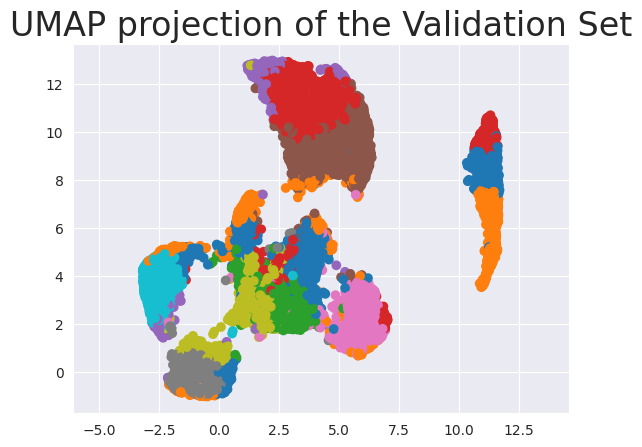

In [35]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette(n_colors=10)[embeddings_to_cluster_map[x]] for x in df_latent_projection['Embedding Index'].astype(int)])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Validation Set', fontsize=24);

In [36]:
clustering = sklearn.cluster.SpectralClustering(n_clusters=10, assign_labels='discretize')
clustering.fit(df_embeddings.drop("Image", axis=1))
embeddings_to_cluster_map = clustering.labels_
embeddings_to_cluster_map

array([1, 2, 2, 4, 9, 8, 0, 9, 2, 6, 5, 3, 4, 9, 0, 3, 6, 8, 2, 7, 1, 8,
       5, 4, 8, 3, 0, 7, 5, 0, 3, 0, 3, 8, 6, 2, 3, 5, 7, 8, 4, 8, 9, 8,
       0, 9, 7, 1, 3, 7, 1, 9, 2, 0, 9, 0, 9, 8, 2, 9, 9, 4, 5, 2, 6, 8,
       2, 6, 9, 0, 0, 2, 6, 8, 8, 1, 5, 7, 4, 5, 3, 8, 4, 1, 9, 0, 2, 5,
       8, 1, 3, 8, 3, 5, 4, 7, 0, 6, 4, 4, 9, 6, 2, 9, 6, 0, 2, 8, 3, 2,
       4, 8, 6, 8, 9, 5, 6, 3, 5, 4, 8, 9, 6, 2, 3, 5, 4, 2])

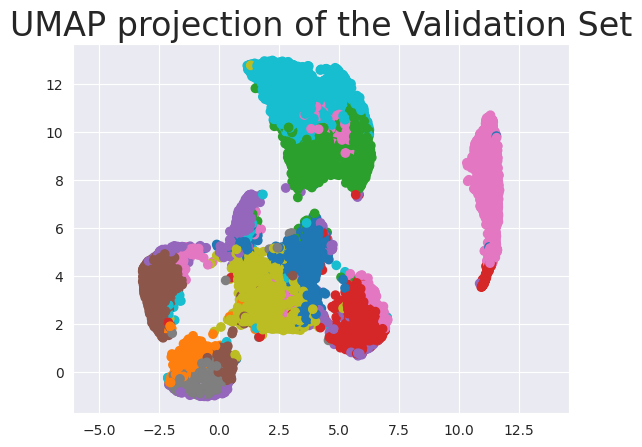

In [37]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette(n_colors=10)[embeddings_to_cluster_map[x]] for x in df_latent_projection['Embedding Index'].astype(int)])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Validation Set', fontsize=24);

In [155]:
true = df_latent_projection.Label

In [156]:
predictions = df_latent_projection.Embedding_Index.map(lambda x: embeddings_to_cluster_map[int(x)])

In [157]:
rand_score(true,predictions)

0.8754351657424511

In [158]:
adjusted_rand_score(true,predictions)

0.35460108564527354

In [38]:
reducer.n_components

2

In [ ]:
clustering

In [166]:
embeddings_to_cluster_map

array([5, 4, 4, 6, 7, 2, 1, 7, 4, 0, 3, 8, 6, 7, 1, 8, 0, 1, 4, 9, 5, 2,
       3, 6, 2, 8, 1, 9, 3, 1, 8, 1, 8, 2, 0, 4, 8, 3, 9, 2, 6, 2, 1, 1,
       1, 7, 9, 5, 8, 9, 5, 7, 4, 1, 7, 1, 7, 1, 4, 7, 7, 6, 3, 4, 0, 2,
       4, 0, 7, 1, 1, 4, 0, 2, 2, 5, 3, 9, 6, 3, 8, 2, 6, 5, 7, 1, 4, 3,
       2, 5, 8, 2, 8, 3, 6, 9, 1, 0, 6, 9, 7, 0, 4, 7, 0, 1, 6, 2, 8, 4,
       6, 2, 0, 2, 4, 3, 0, 6, 3, 6, 2, 7, 0, 4, 8, 3, 6, 4])

In [172]:
df_embeddings.Image[4]

In [184]:
codebook_usage = df_latent_projection.Embedding_Index.value_counts().sort_index()
codebook_usage

0.0      275
1.0      516
2.0      521
3.0      216
4.0      533
        ... 
123.0    444
124.0    391
125.0    382
126.0    459
127.0    684
Name: Embedding_Index, Length: 128, dtype: int64

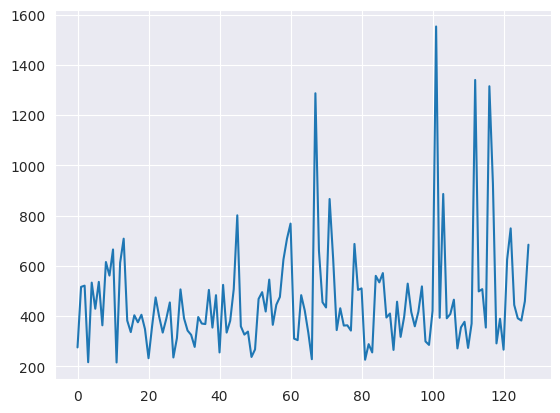

In [196]:
plt.plot(codebook_usage.sort_index())

In [198]:


df_embeddings.Image

0      <PIL.Image.Image image mode=L size=28x28 at 0x...
1      <PIL.Image.Image image mode=L size=28x28 at 0x...
2      <PIL.Image.Image image mode=L size=28x28 at 0x...
3      <PIL.Image.Image image mode=L size=28x28 at 0x...
4      <PIL.Image.Image image mode=L size=28x28 at 0x...
                             ...                        
123    <PIL.Image.Image image mode=L size=28x28 at 0x...
124    <PIL.Image.Image image mode=L size=28x28 at 0x...
125    <PIL.Image.Image image mode=L size=28x28 at 0x...
126    <PIL.Image.Image image mode=L size=28x28 at 0x...
127    <PIL.Image.Image image mode=L size=28x28 at 0x...
Name: Image, Length: 128, dtype: object

In [202]:
for i, image in enumerate(df_embeddings.Image):
    image.save(f'outputs/embedding_images/{i}.jpg')

In [234]:
embedding_to_label_map_true = pd.read_csv('outputs/embedding_images/embedding_to_label_map_true.csv').Label
embedding_to_label_map_true

0      0
1      9
2      7
3      0
4      4
      ..
123    4
124    2
125    6
126    6
127    7
Name: Label, Length: 128, dtype: int64

In [244]:
labels_predicted = df_latent_projection.Embedding_Index.map(lambda embedding_index: embedding_to_label_map_true[embedding_index])

In [249]:
labels_true = df_latent_projection.Label.astype(int)

In [250]:
pd.concat([labels_predicted,labels_true], axis=1)

,Embedding_Index,Label
0,9,9
1,9,9
2,1,1
3,7,7
4,4,9
...,...,...
59387,0,0
59388,9,7
59389,2,3
59390,2,2


In [258]:
accuracy_score(labels_true,labels_predicted)

0.8370319234913793

In [259]:
rand_score(labels_true,labels_predicted)

0.945803063132824

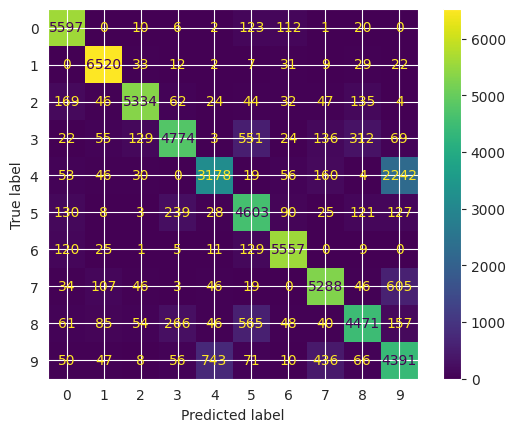

In [260]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(labels_true, labels_predicted)

In [39]:
import scipy.stats as stats

In [42]:
df_latent_projection.iloc[:,0:7]

,z_0,z_1,z_2,z_3,z_4,z_5,z_6
0,0.790783,0.112611,-0.365320,-0.740495,0.366948,0.342123,-0.369900
1,-0.034074,0.287642,0.146036,0.694998,-0.256451,0.236566,0.485155
2,0.163703,0.333918,-0.859075,0.488062,-0.006186,0.566839,-0.185054
3,-0.103752,-0.060530,0.712601,-0.519116,-1.103608,0.200850,0.109875
4,-0.392187,-0.102152,-0.080711,-1.063537,0.062070,0.071863,0.417607
...,...,...,...,...,...,...,...
9211,0.213588,-0.461111,-0.845057,0.289625,-0.091991,0.036175,-0.465942
9212,0.855757,-0.356290,-0.539332,-0.624033,-0.422862,-0.440333,-0.840218
9213,0.084297,-0.835189,0.098833,0.069980,-0.108721,0.304412,-0.903253
9214,0.633008,-0.612371,-0.690741,-0.354190,-0.342959,-0.157012,-0.854659


In [ ]:
stats.probplot()